In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup, SoupStrainer
import requests
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from fake_useragent import UserAgent
import time
import csv
import seaborn as sns
import re

### Scraping beers and links

In [2]:
#scraping beer names and links
links = {"Beer" : [],
        "url" : []}

#iterating through url format
for i in tqdm_notebook(range(0,101,50)):

    url = "https://www.beeradvocate.com/beer/styles/21/?sort=revsD&start={}".format(i)
    r = requests.get(url)
    soup = BeautifulSoup(r.text)

    #adding beer name and link to page
    for item in soup.find_all("tr")[3:-1]:
        try:
            links["Beer"].append(item.find("a").text)
        except:
            links["Beer"].append(np.nan)

        try:
            links["url"].append("https://www.beeradvocate.com/{}".format(item.find("a")["href"]))
        except:
            links["url"].append(np.nan)
        

In [3]:
pd.DataFrame(links).head()

,Beer,url
0,Weihenstephaner Original,https://www.beeradvocate.com//beer/profile/252...
1,Hofbräu Original,https://www.beeradvocate.com//beer/profile/468...
2,Spaten Münchner Hell (Premium Lager),https://www.beeradvocate.com//beer/profile/142...
3,Two Women Lager,https://www.beeradvocate.com//beer/profile/590...
4,Hell Lager,https://www.beeradvocate.com//beer/profile/130...


In [4]:
pd.DataFrame(links).to_csv("./data/urls/urls_helles.csv", index=False)

In [5]:
pd.read_csv("./data/urls/urls_helles.csv").head()

,Beer,url
0,Weihenstephaner Original,https://www.beeradvocate.com//beer/profile/252...
1,Hofbräu Original,https://www.beeradvocate.com//beer/profile/468...
2,Spaten Münchner Hell (Premium Lager),https://www.beeradvocate.com//beer/profile/142...
3,Two Women Lager,https://www.beeradvocate.com//beer/profile/590...
4,Hell Lager,https://www.beeradvocate.com//beer/profile/130...


### Scraping several pages

In [6]:
#creating lists for beer details
b_id, name, brewer, style, abv, rank, av_rating, n_reviews, n_ratings, desc = [],[],[],[],[],[],[],[],[],[]

#creating dataframe for reviews:
all_reviews = pd.DataFrame()


for beer in tqdm_notebook(pd.read_csv("./data/urls/urls_helles.csv")["url"]):
    
    #checking for first page:
    p=0

    #creating lists for review scrape    
    rating, look, smell, taste, feel, overall, review, date = [],[],[],[],[],[],[],[]
    
    for i in range(0,101,25):    

        url = beer+"?view=beer&sort=&start={}".format(i)
        r = requests.get(url)
        soup = BeautifulSoup(r.text)

        #if first page, get details about the beer
        if p==0:

            beer_id = url.split("/")[-2]
            b_id.append(beer_id)

            #finding beer name and brewer
            beer_name = soup.find("div", class_="titleBar").h1.find(text=True, recursive=False)
            name.append(beer_name)
            brew_name = soup.find("div", class_="titleBar").span.text
            brewer.append(brew_name)

            #accessing stats
            stats = soup.find_all("dd", class_="beerstats")
            try:
                style.append(stats[0].b.text)
            except:
                style.append(np.nan)
            try:
                abv.append(stats[1].b.text)
            except:
                abv.append(np.nan)
            try:
                rank.append(stats[2].b.text)
            except:
                rank.append(np.nan)  
            try:
                av_rating.append(stats[3].b.text)
            except:
                av_rating.append(np.nan)
                

            #getting BA review/rating nums
            n_reviews.append(soup.find("span", class_ = "ba-reviews Tooltip").text)
            n_ratings.append(soup.find("span", class_ = "ba-ratings Tooltip").text)

            #brewer's description
            try:
                notes = soup.find("div", style= "clear:both; margin:0; padding:0px 20px; font-size:1.05em;").text.strip("Notes:\n")[:-1]
                desc.append(re.sub(r"\n+", " ", notes))    
                            
            except:
                desc.append(np.nan)

            p=1

        #iterating through reviews
        for rev in soup.find_all("div", class_="user-comment"):
            rating.append(rev.find("span", class_="BAscore_norm").text)


            #pulling out detailed ratings (if statement accounts for when user rating == average rating):
            if rev.find("span", class_="BAscore_norm").text == av_rating:
                details = [d.split(" ")[1] for d in rev.find_all("span", class_="muted")[1].text.split(" | ")]
            else:
                details = [d.split(" ")[1] for d in rev.find("span", class_="muted").text.split(" | ")]

            #if no detailed reatings:
            if len(details) < 5:           
                look.append(np.nan)
                smell.append(np.nan)
                taste.append(np.nan)
                feel.append(np.nan)
                overall.append(np.nan)

                #review text:
                text = str(rev.find("div", attrs={"id": "rating_fullview_content_2"})).split("<br/>")[1:-4]
                review.append("".join(text))

            #if there are detailed ratings:
            else:
                look.append(details[0])
                smell.append(details[1])
                taste.append(details[2])
                feel.append(details[3])
                overall.append(details[4])

                #review text
                text = str(rev.find("div", attrs={"id": "rating_fullview_content_2"})).split("<br/>")[3:-4]
                review.append(re.sub(r"\n+", " ", "".join(text)))

            date.append(rev.find_all("a")[2].text)


    reviews = {"rating" : rating, "look" : look, "smell" : smell, "taste" : taste,
              "feel" : feel, "overall" : overall, "review" : review, "date" : date}

    rev_df = pd.DataFrame(reviews)

    rev_df["id"] = beer_id
    rev_df["name"] = beer_name
    
    all_reviews = pd.concat([all_reviews, rev_df])
        
    
beers = {"id" : b_id, "name" : name, "brewer" : brewer, "style" : style,
         "abv" : abv, "rank" : rank, "av_rating" : av_rating, 
         "n_reviews" : n_reviews, "n_ratings" : n_ratings, "desc" : desc}

beer_df = pd.DataFrame(beers)

all_reviews.reset_index(inplace=True)
all_reviews.drop(columns = ["index"], inplace=True)


In [7]:
beer_df.to_csv("./data/helles_beers.csv",index=False)
all_reviews.to_csv("./data/reviews/helles.csv", index=False)

In [8]:
beer_df.head()

,id,name,brewer,style,abv,rank,av_rating,n_reviews,n_ratings,desc
0,712,Weihenstephaner Original,Bayerische Staatsbrauerei Weihenstephan,German Helles,5.1%,92,4.11,966,"2,504",A good beer takes its time. The long storage m...
1,3062,Hofbräu Original,Hofbräuhaus München,German Helles,5.1%,86,3.83,549,"1,735",
2,1944,Spaten Münchner Hell (Premium Lager),Spaten-Franziskaner-Bräu,German Helles,5.2%,83,3.69,647,"1,539",Marketed as Premium Lager in the US.
3,57471,Two Women Lager,New Glarus Brewing Company,German Helles,5%,86,3.84,332,"1,537",The collaboration of two Craft companies both ...
4,44531,Hell Lager,Surly Brewing Company,German Helles,5%,86,3.84,352,"1,221","unlike a Zwickel Bier from Germany, Hell is n..."


In [9]:
all_reviews.tail()

,rating,look,smell,taste,feel,overall,review,date,id,name
14465,3.56,4,3,3.5,4,4,New kid in town -- at least around here. A Bav...,"Sep 28, 2019",117299,Krombacher Hell
14466,2.85,3.5,2.75,2.75,2.75,3,First time I've seen this beer available local...,"Sep 15, 2019",117299,Krombacher Hell
14467,3.94,4,3.75,4,4,4,Pours a clear yellow with a persistent head. S...,"Sep 15, 2019",117299,Krombacher Hell
14468,3.34,3.75,3.5,3.25,3.25,3.25,Pours a clear golden yellow straw color with l...,"Aug 27, 2019",117299,Krombacher Hell
14469,3.59,4.5,3.5,3.5,3.75,3.5,"L: -pours a clear golden with a big,foamy,whit...","Feb 11, 2016",117299,Krombacher Hell


In [10]:
#looking at no. of reviews per beer
all_reviews["name"].value_counts()

Helles                                  340
Helles Lager                            310
Helles Golden Lager                     250
Lager                                   155
Spaten Münchner Hell (Premium Lager)    125
                                       ... 
Bavarian Helles                          30
Krombacher Hell                          25
Memoria                                  25
Brew For The Crew                        20
Super Awesome Lager                      15
Name: name, Length: 142, dtype: int64

In [11]:
all_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14470 entries, 0 to 14469
Data columns (total 10 columns):
rating     14470 non-null object
look       14165 non-null object
smell      14165 non-null object
taste      14165 non-null object
feel       14165 non-null object
overall    14165 non-null object
review     14470 non-null object
date       14470 non-null object
id         14470 non-null object
name       14470 non-null object
dtypes: object(10)
memory usage: 1.1+ MB


In [15]:
#Some reviews were scraped wrong, as a different part of the html ended up there. This removes those
all_reviews = all_reviews[all_reviews["overall"] != "overall:"]

all_reviews = all_reviews[~all_reviews["review"].str.contains(r"^<span")]

In [16]:
floats = ["rating", "look", "smell", "taste", "feel", "overall"]

for col in floats:
    all_reviews[col] = all_reviews[col].astype(float)

In [17]:
#only including those dates that start with the "MMM " format
all_reviews = all_reviews[all_reviews["date"].str.contains(r"^[A-z]{3}\s")]

In [18]:
all_reviews["date"] = pd.to_datetime(all_reviews["date"])

In [19]:
#imputing missing detail values by using the overal rating
all_reviews = all_reviews.apply(lambda x: x.fillna(x[0]), axis=1)

In [20]:
all_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14257 entries, 0 to 14469
Data columns (total 10 columns):
rating     14257 non-null float64
look       14257 non-null float64
smell      14257 non-null float64
taste      14257 non-null float64
feel       14257 non-null float64
overall    14257 non-null float64
review     14257 non-null object
date       14257 non-null datetime64[ns]
id         14257 non-null object
name       14257 non-null object
dtypes: datetime64[ns](1), float64(6), object(3)
memory usage: 1.2+ MB


In [21]:
all_reviews.describe()

,rating,look,smell,taste,feel,overall
count,14257.000000,14257.000000,14257.000000,14257.000000,14257.000000,14257.000000
mean,3.665908,3.724935,3.557561,3.678940,3.716203,3.719517
std,0.538915,0.563415,0.583727,0.612832,0.592812,0.588937
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.400000,3.500000,3.250000,3.500000,3.500000,3.500000
50%,3.730000,3.750000,3.500000,3.750000,3.750000,3.750000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


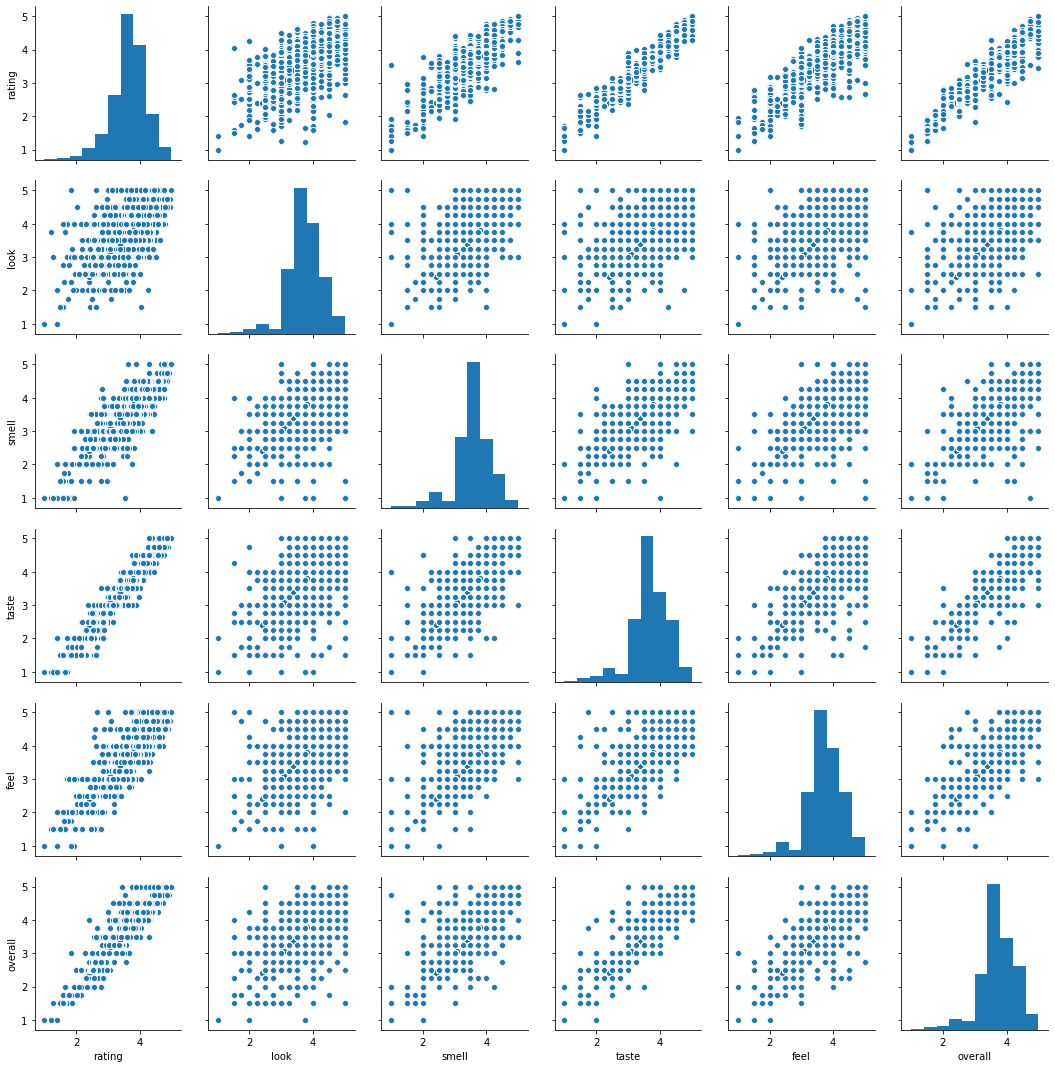

In [22]:
sns.pairplot(all_reviews.drop(columns=["id"]))
plt.show()

In [23]:
all_reviews.drop(columns="id").corr()

,rating,look,smell,taste,feel,overall
rating,1.000000,0.656004,0.872003,0.959703,0.842630,0.926929
look,0.656004,1.000000,0.582794,0.551915,0.584718,0.576515
smell,0.872003,0.582794,1.000000,0.750539,0.675871,0.729192
taste,0.959703,0.551915,0.750539,1.000000,0.766666,0.871398
feel,0.842630,0.584718,0.675871,0.766666,1.000000,0.783241
overall,0.926929,0.576515,0.729192,0.871398,0.783241,1.000000


In [24]:
all_reviews.to_csv("./data/reviews/helles_cleaned.csv", index=False)